CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [30]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
                                       transforms.ToTensor(),
                                       transforms.RandomErasing(p=0.1),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [32]:
SEED = 1
batch_size = 64
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


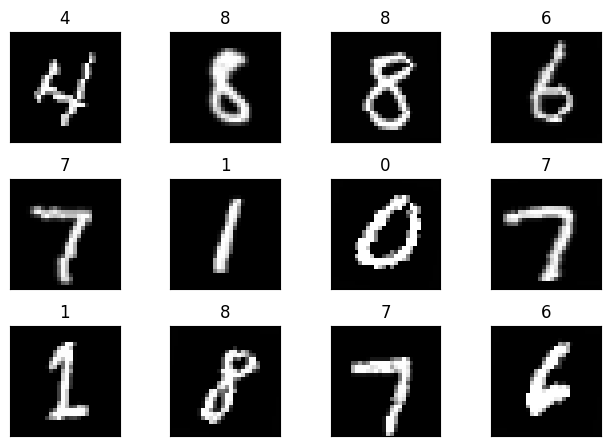

In [33]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [39]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value),
            nn.Conv2d(12, 12, 3),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 15, 3),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value),
            nn.Conv2d(15, 20, 3),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(20, 10, 3),
            nn.BatchNorm2d(10)
        )
        self.gap = nn.AvgPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.flatten().view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

| Layer                         | Rin  | Rout | Jin  | Jout |
|-------------------------------|-------|------|------|------|
| **Input Image (28x28)**       | 1     | 1    | 1    | 1    |
| **Conv Block 1**              |       |      |      |      |
| Conv2d(1, 10, K=3, P=0, S=1)  | 1     | 3    | 1    | 1    |
| Conv2d(10, 12, K=3, P=0, S=1) | 3     | 5    | 1    | 1    |
| MaxPool2d(K=2, S=2)           | 5     | 6    | 1    | 2    |
| **Conv Block 2**              |       |      |      |      |
| Conv2d(12, 16, K=3, P=0, S=1) | 6     | 10   | 2    | 2    |
| Conv2d(16, 20, K=3, P=0, S=1) | 10    | 14   | 2    | 2    |
| MaxPool2d(K=2, S=2)           | 14    | 16   | 2    | 4    |
| **Conv Block 3**              |       |      |      |      |
| Conv2d(20, 10, K=3, P=0, S=1) | 16    | 24   | 4    | 4    |
| AvgPool2d(K=2, S=2)           | 24    | 26   | 4    | 8    |
| **GAP (Global Avg Pool)**     | 26    | Full | 8    | -    |


In [40]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
             ReLU-10           [-1, 12, 12, 12]               0
          Dropout-11           [-1, 12, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,635
             ReLU-13           [-1, 15, 10, 10]               0
      BatchNorm2d-14           [-1, 15,

CODE BLOCK: 8

In [41]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [42]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred,  target.squeeze())
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [43]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()
  current_lr = optimizer.param_groups[0]['lr']
  print(f'Learning Rate after epoch {epoch}: {current_lr}')

Epoch 1


Train: Loss=0.3806 Batch_id=937 Accuracy=92.08: 100%|██████████| 938/938 [00:53<00:00, 17.40it/s]


Test set: Average loss: 0.0008, Accuracy: 9860/10000 (98.60%)

Learning Rate after epoch 1: 0.15
Epoch 2


Train: Loss=0.1717 Batch_id=937 Accuracy=94.72: 100%|██████████| 938/938 [00:53<00:00, 17.38it/s]


Test set: Average loss: 0.0006, Accuracy: 9892/10000 (98.92%)

Learning Rate after epoch 2: 0.15
Epoch 3


Train: Loss=0.2330 Batch_id=937 Accuracy=95.30: 100%|██████████| 938/938 [00:55<00:00, 16.93it/s]


Test set: Average loss: 0.0006, Accuracy: 9899/10000 (98.99%)

Learning Rate after epoch 3: 0.15
Epoch 4


Train: Loss=0.0342 Batch_id=937 Accuracy=95.80: 100%|██████████| 938/938 [00:54<00:00, 17.14it/s]


Test set: Average loss: 0.0005, Accuracy: 9914/10000 (99.14%)

Learning Rate after epoch 4: 0.15
Epoch 5


Train: Loss=0.0754 Batch_id=937 Accuracy=96.00: 100%|██████████| 938/938 [00:55<00:00, 17.01it/s]


Test set: Average loss: 0.0004, Accuracy: 9921/10000 (99.21%)

Learning Rate after epoch 5: 0.075
Epoch 6


Train: Loss=0.2253 Batch_id=937 Accuracy=96.29: 100%|██████████| 938/938 [00:56<00:00, 16.74it/s]


Test set: Average loss: 0.0004, Accuracy: 9935/10000 (99.35%)

Learning Rate after epoch 6: 0.075
Epoch 7


Train: Loss=0.1691 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [00:54<00:00, 17.26it/s]


Test set: Average loss: 0.0004, Accuracy: 9935/10000 (99.35%)

Learning Rate after epoch 7: 0.075
Epoch 8


Train: Loss=0.2425 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s]


Test set: Average loss: 0.0004, Accuracy: 9930/10000 (99.30%)

Learning Rate after epoch 8: 0.075
Epoch 9


Train: Loss=0.0569 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:55<00:00, 16.85it/s]


Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.39%)

Learning Rate after epoch 9: 0.075
Epoch 10


Train: Loss=0.1766 Batch_id=937 Accuracy=96.68: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s]


Test set: Average loss: 0.0003, Accuracy: 9944/10000 (99.44%)

Learning Rate after epoch 10: 0.0375
Epoch 11


Train: Loss=0.0945 Batch_id=937 Accuracy=96.79: 100%|██████████| 938/938 [00:53<00:00, 17.47it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Learning Rate after epoch 11: 0.0375
Epoch 12


Train: Loss=0.0179 Batch_id=937 Accuracy=96.87: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]


Test set: Average loss: 0.0004, Accuracy: 9930/10000 (99.30%)

Learning Rate after epoch 12: 0.0375
Epoch 13


Train: Loss=0.0796 Batch_id=937 Accuracy=96.84: 100%|██████████| 938/938 [00:54<00:00, 17.37it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Learning Rate after epoch 13: 0.0375
Epoch 14


Train: Loss=0.1719 Batch_id=937 Accuracy=96.83: 100%|██████████| 938/938 [00:53<00:00, 17.44it/s]


Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.39%)

Learning Rate after epoch 14: 0.0375
Epoch 15


Train: Loss=0.0231 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:55<00:00, 16.85it/s]


Test set: Average loss: 0.0003, Accuracy: 9937/10000 (99.37%)

Learning Rate after epoch 15: 0.01875
Epoch 16


Train: Loss=0.0204 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:53<00:00, 17.41it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Learning Rate after epoch 16: 0.01875
Epoch 17


Train: Loss=0.0620 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [00:54<00:00, 17.37it/s]


Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.43%)

Learning Rate after epoch 17: 0.01875
Epoch 18


Train: Loss=0.0332 Batch_id=937 Accuracy=97.00: 100%|██████████| 938/938 [00:54<00:00, 17.06it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Learning Rate after epoch 18: 0.01875
Epoch 19


Train: Loss=0.1469 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s]


Test set: Average loss: 0.0003, Accuracy: 9948/10000 (99.48%)

Learning Rate after epoch 19: 0.01875
Epoch 20


Train: Loss=0.0965 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [00:53<00:00, 17.44it/s]


Test set: Average loss: 0.0003, Accuracy: 9937/10000 (99.37%)

Learning Rate after epoch 20: 0.009375
